In [1]:
import os
import re
from types import SimpleNamespace
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import ipywidgets as widgets

os.environ.setdefault("KERAS_BACKEND", "torch")  # Use PyTorch backend unless specified otherwise

import keras
import numpy as np
import torch

keras.utils.set_random_seed(42)

from mnist import MNIST

# Loss Landscape Visualization

In this notebook we will train simple neural network on MNIST dataset and visualize its loss landscape.

## Training Neural Network

In this section we:
- load dataset
- define neural network architecture
- save initial parameters
- train the model
- save trained parameters

In [12]:
mnist = MNIST()
args = SimpleNamespace(batch_size=50, epochs=10, hidden_layer=128, learning_rate=1e-2,
                       learning_rate_final=1e-3)

In [13]:
model = keras.Sequential([
    keras.layers.Input(shape=[MNIST.H, MNIST.W, MNIST.C]),
    keras.layers.Rescaling(1 / 255),
    keras.layers.Flatten(),
    keras.layers.Dense(args.hidden_layer, activation="relu"),
    keras.layers.Dense(MNIST.LABELS, activation="softmax"),
])

max_steps = (mnist.train.size // args.batch_size) * args.epochs

learning_rate = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args.learning_rate,
    decay_rate=args.learning_rate_final / args.learning_rate,
    decay_steps=max_steps
)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy("accuracy")],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Save initial parameters/weights of the model.
theta_0 = [param.data.clone() for param in model.parameters()]
theta_0

[tensor([[ 0.0188, -0.0531, -0.0275,  ..., -0.0293,  0.0531, -0.0326],
         [ 0.0408, -0.0645,  0.0625,  ...,  0.0544, -0.0456,  0.0718],
         [-0.0452,  0.0373,  0.0305,  ...,  0.0380,  0.0310,  0.0340],
         ...,
         [-0.0638, -0.0676,  0.0280,  ...,  0.0232, -0.0309, -0.0735],
         [-0.0235, -0.0638, -0.0497,  ..., -0.0683,  0.0726, -0.0394],
         [-0.0447, -0.0136,  0.0567,  ...,  0.0586, -0.0378,  0.0362]],
        device='cuda:0'),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

In [15]:
# If the model is saved in filesystem - load it, otherwise train it and save.

if os.path.exists('model.weights.h5'):
    model.load_weights('model.weights.h5')
else:
    model.fit(
        mnist.train.data["images"], mnist.train.data["labels"],
        batch_size=args.batch_size, epochs=args.epochs,
        validation_data=(mnist.dev.data["images"], mnist.dev.data["labels"])
    )
    model.save_weights('model.weights.h5')

In [16]:
# Save trained parameters of the model.
theta_star = [param.data.clone() for param in model.parameters()]
theta_star

[tensor([[ 0.0188, -0.0531, -0.0275,  ..., -0.0293,  0.0531, -0.0326],
         [ 0.0408, -0.0645,  0.0625,  ...,  0.0544, -0.0456,  0.0718],
         [-0.0452,  0.0373,  0.0305,  ...,  0.0380,  0.0310,  0.0340],
         ...,
         [-0.0638, -0.0676,  0.0280,  ...,  0.0232, -0.0309, -0.0735],
         [-0.0235, -0.0638, -0.0497,  ..., -0.0683,  0.0726, -0.0394],
         [-0.0447, -0.0136,  0.0567,  ...,  0.0586, -0.0378,  0.0362]],
        device='cuda:0'),
 tensor([-0.2900, -0.0700,  0.0203,  0.0436, -0.0170, -0.2583,  0.3683, -0.1987,
         -0.0456, -0.2884, -0.0599, -0.0789,  0.0081, -0.4519, -0.0600, -0.0042,
          0.1422,  0.0932,  0.0295, -0.0599,  0.4157,  0.1814, -0.0599, -0.0137,
         -0.6069,  0.4647, -0.0476,  0.1774, -0.2244, -0.1014, -0.0739, -0.1043,
         -0.0599,  0.2158, -0.0722, -0.0385, -0.0738,  0.2654, -0.1365,  0.0305,
         -0.3626, -0.0375, -0.0632,  0.1315, -0.6022, -0.0475, -0.1004, -0.0119,
         -0.0598, -0.0685, -0.4184, -0.0599, -0

## Visualizing the Loss Landscape

We use method explained in [Li et al. 2018](https://arxiv.org/pdf/1712.09913):

1. Selection of Direction Vectors
2. Parameter Space Projection
3. Loss Computation
4. Visualization

### Selection of Direction Vectors

$d_1$ is our first vector: $$d_1 = \theta^* - \theta_0.$$

$d_2$ we is random vector, orthogonal to $d_1$.

We work with weights of the model, as with one single vector. But to compute loss later, we need to preserve model's structure of weights, and cannot flatten all weights tensors into one single vector. We have to compute $d_1$ and $d_2$ part-wise.

We use Gram Schmidt Orthogonalization to get $d_2$.

![](img/d1_dot_d2.png)

In [27]:
d1 = [t_star - t_0 for t_star, t_0 in zip(theta_star, theta_0)]
d2 = [torch.randn_like(d) for d in d1]

d1_dot_d2 = sum([torch.sum(d1_i * d2_i) for d1_i, d2_i in zip(d1, d2)])
d1_dot_d2

tensor(-126.3126, device='cuda:0')

In [22]:
d1_dot_d1 = sum([torch.sum(d1_i * d1_i) for d1_i in d1])
scale = d1_dot_d2 / d1_dot_d1

d2_orto = [d2_i - scale * d1_i for d1_i, d2_i in zip(d1, d2)]

d1_norm = torch.sqrt(sum([torch.sum(d_i ** 2) for d_i in d1]))
d2_orto_norm = torch.sqrt(sum([torch.sum(d_i ** 2) for d_i in d2_orto]))

d1 = [d_i / d1_norm for d_i in d1]
d2 = [d_i / d2_orto_norm for d_i in d2_orto]

In [94]:
dot = sum([torch.sum(d1_i * d2_i) for d1_i, d2_i in zip(d1, d2)])
dot

tensor(-2.0373e-10, device='cuda:0')

In [95]:
alpha = beta = np.linspace(-1000, 1000, 100)
alpha_mesh, beta_mesh = np.meshgrid(alpha, beta)

In [96]:
loss_values = np.zeros_like(alpha_mesh)


def compute_loss_values(loss_values):
    for i in tqdm(range(alpha_mesh.shape[0]), desc='Loss computation'):
        for j in range(beta_mesh.shape[1]):
            # Compute new parameters
            theta = [theta_star_i + alpha_mesh[i, j] * d1_i + beta_mesh[i, j] * d2_i
                     for theta_star_i, d1_i, d2_i in zip(theta_star, d1, d2)]

            # Load parameters into the model
            for param, theta_i in zip(model.parameters(), theta):
                param.data = theta_i

            # Evaluate loss on validation set
            scalars = model.evaluate(mnist.dev.data["images"], mnist.dev.data["labels"],
                                     batch_size=min(mnist.dev.data['images'].shape[0], 5000), verbose=0)
            loss_values[i, j] = scalars[0]

In [97]:
if os.path.exists('loss_values.npy'):
    loss_values = np.load('loss_values.npy')
else:
    compute_loss_values(loss_values)
    np.save('loss_values.npy', loss_values)

In [98]:
def plot_loss_landscape(elev=40, azim=20):
    fig = plt.figure(figsize=(10, 10), constrained_layout=True)
    ax = fig.add_subplot(projection='3d')

    # Plot the surface
    surf = ax.plot_surface(
        alpha_mesh,  # X-axis values
        beta_mesh,  # Y-axis values
        loss_values,  # Z-axis values (loss)
        cmap=cm.coolwarm,
        edgecolor='black',
        linewidth=0.5,
        antialiased=True
    )

    # Add a color bar to map colors to loss values
    fig.colorbar(surf, shrink=0.5, aspect=20)

    # Set labels and title
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Beta')
    ax.set_zlabel('Loss')
    ax.set_title('3D Loss Landscape')

    # Optional: Adjust the viewing angle
    ax.view_init(elev=elev, azim=azim)  # Elevation and azimuthal angles

    plt.show()

In [99]:
elevation_slider = widgets.IntSlider(min=-90, max=90, step=10, value=40, description='Elevation',
                                     continuous_update=False, style={'description_width': 'initial'})
azimuth_slider = widgets.IntSlider(min=0, max=360, step=10, value=20, description='Azimuth Angle',
                                   continuous_update=False, style={'description_width': 'initial'})

widgets.interact(plot_loss_landscape, elev=elevation_slider, azim=azimuth_slider)
plt.show()

interactive(children=(IntSlider(value=40, continuous_update=False, description='Elevation', max=90, min=-90, s…

# Neurons visualizations

### Visualizing weights of the first hidden layer

In [100]:
def get_ith_neuron_image(i):
    return theta_star[0][:, i].reshape(28, 28).cpu().detach().numpy()


get_ith_neuron_image(0)

array([[ 1.88371092e-02,  4.08158004e-02, -4.51814234e-02,
         4.60608378e-02, -3.02801728e-02, -4.34033684e-02,
        -3.69116664e-03,  1.34845823e-03,  6.83250502e-02,
        -1.00409016e-02, -2.01657340e-02, -3.57591398e-02,
        -7.28134513e-02,  5.46814278e-02, -2.68688053e-03,
        -7.78069571e-02, -1.93568505e-02,  2.26356909e-02,
         4.34202924e-02, -7.29111433e-02,  2.59754434e-02,
        -2.22740248e-02, -5.21840900e-02, -4.94082570e-02,
        -2.72345096e-02, -1.20177865e-02, -8.28750432e-03,
        -3.88667732e-02],
       [-5.11118509e-02, -7.93505237e-02,  3.05279046e-02,
         2.83949673e-02, -1.41286626e-02, -2.15247944e-02,
        -1.36367694e-01, -3.92277613e-02, -1.46044893e-02,
        -1.06560789e-01, -1.06972836e-01, -4.62338654e-03,
        -1.33952379e-01, -4.39819276e-01, -2.55807638e-01,
         4.18845154e-02,  1.99255962e-02,  3.55649218e-02,
         1.12902671e-02,  7.74211958e-02,  4.19215560e-02,
         3.82500142e-03,  1.47

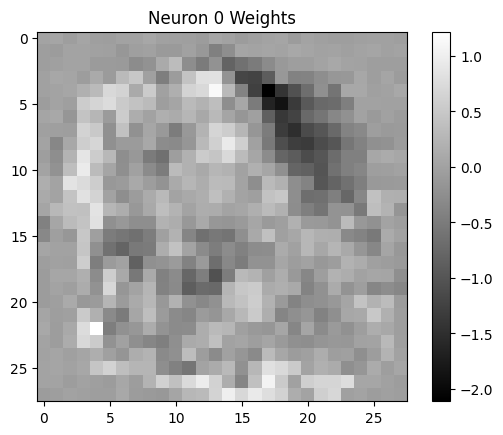

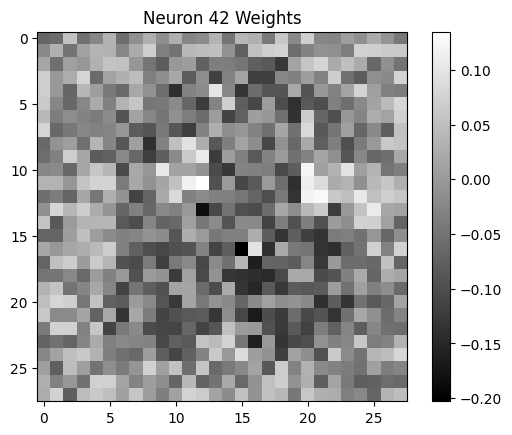

In [109]:
def visualize_ith_neuron(i):
    img = plt.imshow(get_ith_neuron_image(i), cmap='gray')
    plt.title(f'Neuron {i} Weights')
    plt.colorbar(img)
    plt.show()


visualize_ith_neuron(0)
visualize_ith_neuron(42)

### Activation Maximization

In [208]:
input_img = keras.Variable(keras.random.normal(shape=[1, MNIST.H, MNIST.W, MNIST.C], seed=42), trainable=True)

In [209]:
optimizer = torch.optim.Adam([input_img.value])

In [205]:
model.layers

[<Rescaling name=rescaling_4, built=True>,
 <Flatten name=flatten_4, built=True>,
 <Dense name=dense_8, built=True>,
 <Dense name=dense_9, built=True>]

In [369]:
for i in range(1000):
    optimizer.zero_grad()
    flattened = model.layers[1](input_img)
    activations = model.layers[2](flattened)
    loss = -activations[0, 2]
    loss.backward()
    optimizer.step()
    if i % 200 == 0:
        print(activations[0, 2])

tensor(1691.3995, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1735.4308, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1779.4506, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1823.4562, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1867.4539, device='cuda:0', grad_fn=<SelectBackward0>)


In [370]:
img = input_img.value.detach().cpu().numpy().squeeze()

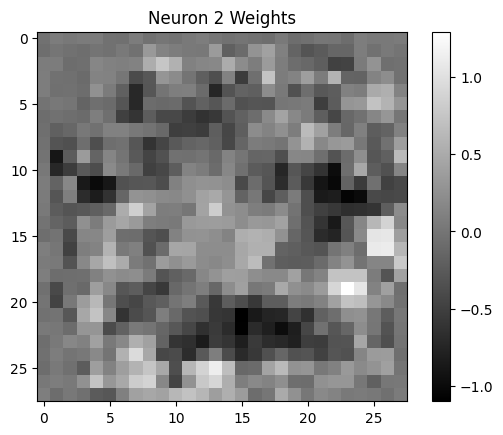

In [375]:
visualize_ith_neuron(2)

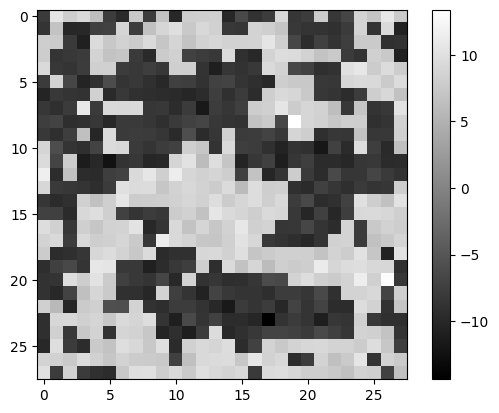

In [374]:
ax = plt.imshow(img, cmap='gray')
plt.colorbar(ax)